In [1]:
import jax
import jax.numpy as jnp
from jax import random
from jax import jit, vmap, grad
from jax import scipy as jsc
import matplotlib.pylab as plt
import seaborn as sns
from scipy.stats import chi2
import numpy as np

sns.set(style="whitegrid")

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
def pick_top_k_by_square(samples, k):
    # Sort samples based on their squared values in descending order
    sorted_indices = jnp.argsort(jnp.square(samples))[-k:]  # Get the top k based on x^2
    return samples[sorted_indices]

def pick_random(samples, k):
    return samples[-k:]

vmaped_pick_top_k_by_square = vmap(pick_top_k_by_square, in_axes=(0, None))
vmaped_pick_random_k = vmap(pick_random, in_axes=(0, None))

def get_minmax_order_statistic_and_random(m, s, key, k, batch_sz):
    print(f"m = {m}, k = {k}")
    pool = s * jax.random.normal(key, shape=(batch_sz, m))
    max_samples = vmaped_pick_top_k_by_square(pool, k)  # Shape (size, k)
    random_samples = vmaped_pick_random_k(pool, k)
    return max_samples, random_samples

In [3]:
def order_statistic_pdf(labeled_x, m, k, s, usechi2=True):
    labeled_x_normalize_sq = jnp.sort(jnp.square(labeled_x)) / (s**2)

    binomial_term = jax.scipy.special.factorial(m) // jax.scipy.special.factorial(m - k)
    const = 1 / (s**2)

    def product_term(i):
        if not usechi2:
            return (1 / (s * jnp.sqrt(2 * jnp.pi))) * jnp.exp(
                -(labeled_x[i] ** 2) / (2 * (s**2))
            )
        return chi2.pdf(labeled_x_normalize_sq[i], df=1) * (
            jnp.sqrt(labeled_x_normalize_sq[i]) / s
        )

    product = jnp.prod(jnp.array([product_term(i) for i in range(m - k, m)]))
    phi_term = (chi2.cdf(labeled_x_normalize_sq[m - k + 1], df=1)) ** (m - k)

    if not usechi2:
        phi_term = (
            2 * jax.scipy.stats.norm.cdf(jnp.abs(labeled_x[m - k + 1]) / s) - 1
        ) ** (m - k)

    result = binomial_term * product * phi_term
    return result

m = 20, k = 1
(50000, 1) (50000, 1)


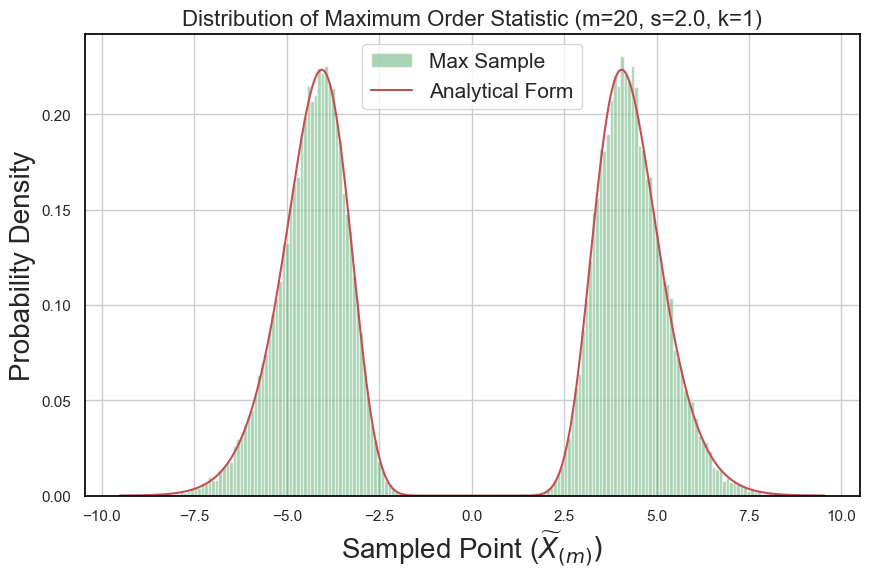

In [4]:
key = jax.random.PRNGKey(0)
# Parameters
m = 20  # Sample size
s = 2.0  # Standard deviation
size = 50000  # Number of samples to generate for comparison
k = 1

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Simulation
key = jax.random.PRNGKey(0)
max_samples, random_samples = get_minmax_order_statistic_and_random(
    m, s, key, k, batch_sz=size
)
print(max_samples.shape,random_samples.shape)
# Results
x = jnp.linspace(jnp.min(max_samples), jnp.max(max_samples), 1001)  # how plot when k > 1?
pdf_values = [order_statistic_pdf(jnp.array([xMax]), m, k, s) for xMax in x]

plt.hist(max_samples, bins=200, density=True, alpha=0.5, color="g", label="Max Sample")
# plt.hist(random_samples, bins=200, density=True, alpha=0.5, color="b", label="Random Sample")
plt.plot(x, pdf_values, "r", label=r"Analytical Form")

plt.xlabel(r"Sampled Point ($\widetilde{X}_{(m)})$", size=20)
plt.ylabel("Probability Density", size=20)
plt.title(
    "Distribution of Maximum Order Statistic (m=%i, s=%0.1f, k=%i)" % (m, s, k), size=16
)
plt.legend(prop={"size": 15})
plt.grid(True)
ax.spines["top"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
plt.savefig("../plots/derived_k1.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [32]:
pool_sizes = jnp.array(
    [
        2,
        5,
        10,
        20,
        30,
        40,
        50,
        60,
        80,
        100,
        150,
        200,
        300,
        400,
        500,
        600,
        800,
        1000,
        1500,
        2000,
        3000,
        4000,
        5000,
        7000,
        10000,
        15000,
        20000,
        30000,
        40000,
    ]
)

In [33]:
def calculate_diff_m(k, s1=1.0, size1=3000, s2=2.0, size2=500):
    samples1 = jnp.array(
        [
            simulate_minmax_order_statistic(pool_sizes[i], s1, key, k, size1)
            for i in range(pool_sizes.shape[0])
        ]
    )
    simulated_variance = jnp.var(samples, axis=1)
    samples2 = jnp.array(
        [
            simulate_minmax_order_statistic(pool_sizes[i], s2, key, k, size2)
            for i in range(pool_sizes.shape[0])
        ]
    )
    simulated_variance2 = jnp.var(samples2, axis=1)
    return simulated_variance, simulated_variance2

In [7]:
# Parameters
def plot_gain_diffm(simulated_variance, simulated_variance2):
    x = jnp.log(pool_sizes[15:]).reshape(-1, 1)
    y = simulated_variance[15:]

    # Create polynomial features
    poly_features = PolynomialFeatures(degree=2)
    x_poly = poly_features.fit_transform(x)
    # Fit the polynomial regression model
    model = LinearRegression()
    model.fit(x_poly, y)

    # Predict using the trained model
    x_test = jnp.linspace(jnp.log(1.0), 13.0, 101).reshape(-1, 1)  # New input value
    x_test_poly = poly_features.transform(x_test)
    y_pred = model.predict(x_test_poly)
    plt.plot(
        pool_sizes,
        simulated_variance,
        lw=3,
        color="steelblue",
        label="3000 draws per simulation",
    )
    plt.plot(
        pool_sizes,
        simulated_variance2 / 4,
        lw=2,
        linestyle="--",
        color="indianred",
        label="500 draws per simulation",
    )
    plt.plot(
        jnp.exp(x_test), y_pred, color="orange", label="Fit (second order polynomial)"
    )

    plt.axhline(y=1, color="black", linestyle="--")

    plt.xscale("log")
    plt.ylim([0, 25])
    plt.xlim([1, 5e4])

    plt.ylabel("Gain Factor, g(m)", size=22)
    plt.xlabel("Pool Size, m", size=22)
    plt.grid()

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle="round", facecolor="lightyellow", alpha=0.7)
    textstr = "g(m) = %0.2f + %0.2f $\ln(m)$ + %0.2f $\ln(m)^2$" % (
        model.intercept_,
        model.coef_[0][1],
        model.coef_[0][2],
    )
    # place a text box in upper left in axes coords
    plt.text(15, 3.5, textstr, fontsize=13.5, verticalalignment="top", bbox=props)

    plt.legend(loc=2, prop={"size": 14})
    plt.xticks(size=15)
    plt.yticks(size=15)

    x = jnp.log(pool_sizes2[20:]).reshape(-1, 1)
    y = simulated_variance2[20:] / 4.0
    poly_features = PolynomialFeatures(degree=2)
    x_poly = poly_features.fit_transform(x)
    model = LinearRegression()
    model.fit(x_poly, y)

    plt.savefig("gain_factor_linear_regression_k1.pdf", bbox_inches="tight")

In [53]:
# Parameters
budgets = jnp.array(
    [1, 2, 5, 10, 50, 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000] #
)

simulated_gain = []
for i in range(len(budgets)):
    max_samples, random_samples = get_minmax_order_statistic_and_random(10000, s=1.0, key=key, k=budgets[i], batch_sz=1000)
    gain = jnp.linalg.norm(jnp.var(max_samples, axis=0)) / jnp.linalg.norm(jnp.var(random_samples, axis=0))
    simulated_gain.append(gain)

simulated_gain

m = 10000, k = 1
m = 10000, k = 2
m = 10000, k = 5
m = 10000, k = 10
m = 10000, k = 50
m = 10000, k = 100
m = 10000, k = 250
m = 10000, k = 500
m = 10000, k = 750
m = 10000, k = 1000
m = 10000, k = 2500
m = 10000, k = 5000
m = 10000, k = 7500
m = 10000, k = 10000


[Array(16.250832, dtype=float32),
 Array(15.505722, dtype=float32),
 Array(13.986551, dtype=float32),
 Array(12.655622, dtype=float32),
 Array(9.835432, dtype=float32),
 Array(8.625784, dtype=float32),
 Array(7.033771, dtype=float32),
 Array(5.8566747, dtype=float32),
 Array(5.1901946, dtype=float32),
 Array(4.7277627, dtype=float32),
 Array(3.3416586, dtype=float32),
 Array(2.4383962, dtype=float32),
 Array(1.9978615, dtype=float32),
 Array(1.7307402, dtype=float32)]

In [54]:
simulated_gain2 = []
for i in range(len(budgets)):
    max_samples, random_samples = get_minmax_order_statistic_and_random(10000, s=2.0, key=key, k=budgets[i], batch_sz=500)
    gain = jnp.linalg.norm(jnp.var(max_samples, axis=0)) / jnp.linalg.norm(jnp.var(random_samples, axis=0))
    simulated_gain2.append(gain)
simulated_gain2

m = 10000, k = 1
m = 10000, k = 2
m = 10000, k = 5
m = 10000, k = 10
m = 10000, k = 50
m = 10000, k = 100
m = 10000, k = 250
m = 10000, k = 500
m = 10000, k = 750
m = 10000, k = 1000
m = 10000, k = 2500
m = 10000, k = 5000
m = 10000, k = 7500
m = 10000, k = 10000


[Array(17.197653, dtype=float32),
 Array(15.532885, dtype=float32),
 Array(13.945873, dtype=float32),
 Array(12.934294, dtype=float32),
 Array(9.975797, dtype=float32),
 Array(8.669387, dtype=float32),
 Array(7.0170093, dtype=float32),
 Array(5.836732, dtype=float32),
 Array(5.17545, dtype=float32),
 Array(4.7119923, dtype=float32),
 Array(3.3339777, dtype=float32),
 Array(2.436481, dtype=float32),
 Array(1.9949925, dtype=float32),
 Array(1.727612, dtype=float32)]

In [83]:
def plot_gain_diffk(simulated_gain, simulated_gain2):
    x = jnp.log(budgets).reshape(-1, 1)
    y = simulated_gain

    # Create polynomial features
    poly_features = PolynomialFeatures(degree=2)
    x_poly = poly_features.fit_transform(x)
    # Fit the polynomial regression model
    model = LinearRegression()
    model.fit(x_poly, y)

    # Predict using the trained model
    x_test = jnp.linspace(jnp.log(1.0), 13.0, 101).reshape(-1, 1)  # New input value
    x_test_poly = poly_features.transform(x_test)
    y_pred = model.predict(x_test_poly)
    plt.plot(
        budgets,
        simulated_gain,
        lw=3,
        color="steelblue",
        label="3000 draws per simulation",
    )
    plt.plot(
        budgets,
        simulated_gain2,
        lw=2,
        linestyle='--',
        color="indianred",
        label="500 draws per simulation",
    )
    plt.plot(
        jnp.exp(x_test), y_pred, color="orange", label="Fit (second order polynomial)"
    )

    plt.axhline(y=1, color="black", linestyle="--")

    plt.xscale("log")
    plt.xlim([1, 1e4])
    plt.ylim([0, 18])

    plt.ylabel("Gain Factor, g(m=10000, k)", size=22)
    plt.xlabel("Budget Size, k", size=22)

    # these are matplotlib.patch.Patch properties
    props = dict(
        boxstyle="round", facecolor="lightyellow", alpha=0.7, edgecolor="black"
    )
    print(model.coef_)
    textstr = "g(k) = %0.3f + %0.3f $\ln(k)$ + %0.3f $\ln(k)^2$" % (
        model.intercept_,
        model.coef_[1],
        model.coef_[2],
        # model.coef_[3],
        # model.coef_[4],
        # model.coef_[5],
    )
    # place a text box in upper left in axes coords
    # plt.text(10, 4.5, textstr, fontsize=13.5, verticalalignment='top', bbox=props)
    ax = plt.gca()
    ax.text(
        0.03,
        .12,
        textstr,
        fontsize=13.5,
        verticalalignment="center",
        bbox=props,
        transform=ax.transAxes,
    )

    plt.legend(loc=1, prop={"size": 14})
    plt.xticks(size=15)
    plt.yticks(size=15)

    # Add gridlines
    ax = plt.gca()  # Get current Axes
    custom_x_vals = [10, 100, 1000, 1e4]
    ax.set_xticks(custom_x_vals)

    # Turn off all automatic gridlines
    ax.grid(False)

    # Re-enable only y-axis gridlines
    ax.yaxis.grid(
        True, which="major", linestyle="-", linewidth=0.8, color="gray", alpha=0.8
    )

    # Manually add vertical gridlines at desired x-values
    for x in custom_x_vals:
        ax.axvline(x=x, color="gray", linestyle="-", linewidth=0.8, alpha=0.8)

    # Add black border around the plot

    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.5)

    plt.savefig("../plots/gain_factor_linear_regression_m10k.pdf", bbox_inches="tight")

[ 0.        -1.8626288  0.0233693]


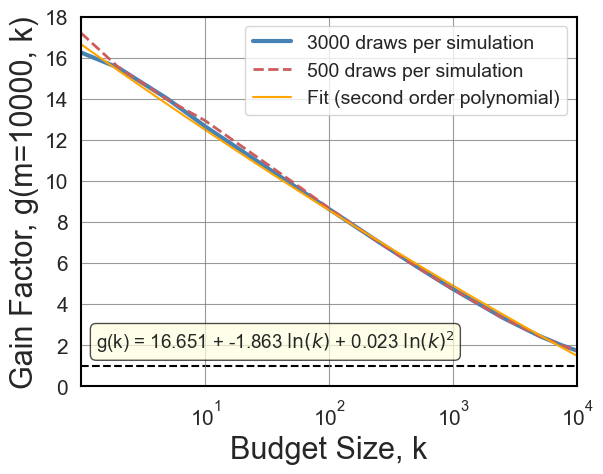

In [84]:
simulated_gain = jnp.array(simulated_gain)
simulated_gain2 = jnp.array(simulated_gain2)
plot_gain_diffk(simulated_gain, simulated_gain2)